In [1]:
import setigen as stg
import bifrost as bf
from bifrost.fdmt import Fdmt
import numpy as np
import blimpy as bl
import cupy as cp
import matplotlib.pyplot as plt
from astropy import units as u

import hyperseti
from hyperseti import dedoppler
from hyperseti import plotting 

import time as tim
from timeit import default_timer as timer

%matplotlib inline

fdmt= Fdmt()




def ddframecenteredtwice(stgframe, exponent):
    fr=stgframe
    drift_rate=fr.df/fr.dt
    frequency = fr.dt*fr.tchans*drift_rate
    max_delay=int(frequency*2)
    #print(max_delay)
    #max_delay = max_drift_rate 

#     def get_gulp(idx):
#         #d_cpu = np.ascontiguousarray(np.expand_dims(fr.data,axis=0))
#         d_cpu = np.ascontiguousarray(np.expand_dims(fr.data.squeeze(), axis=0)[..., idx * gulp_size:(idx+1) * gulp_size])

#         return d_cpu
    
    # d_cpu = get_gulp(0)
    d_cpu = np.expand_dims(fr.data, axis=0)
    #print(d_cpu.shape)

    ## Initialize FDMT
    n_disp = max_delay
    n_time = d_cpu.shape[2]
    n_chan = d_cpu.shape[1]
    fdmt.init(n_chan, n_disp, fr.fch1, fr.df, space="cuda", exponent=exponent)


    # Input shape is (1, n_freq, n_time)
    d_in = bf.ndarray(d_cpu, dtype='f32', space='cuda')
    d_out = bf.ndarray(np.zeros(shape=(1, n_disp, n_time)), dtype='f32', space='cuda')
    d_out2 = bf.ndarray(np.zeros(shape=(1, n_disp, n_time)), dtype='f32', space='cuda')

    # Execute FDMT
    

    #d_out2 = bf.ndarray(np.zeros(shape=(1, n_disp, n_time)), dtype='f32', space='cuda')
    
    start = timer()
    for ii in range(128):
        fdmt.execute(d_in, d_out, negative_delays=True)
        fdmt.execute(d_in, d_out2, negative_delays=False)
    end = timer()
    time=end-start
    timesFDMT.append(time)
    
    d_out = d_out.copy(space='system')
    d_out2 = d_out2.copy(space='system')
    
    
    img = cp.asarray(d_out2.squeeze())
    peaks, xvals, yvals = hyperseti.peak.prominent_peaks(img, num_peaks=1, min_xdistance=100, min_ydistance=100, threshold=100)
    print(peaks)    
    
    #d_out = d_out.copy(space='system')
    #d_out2 = d_out2.copy(space='system')
    # plt.figure(figsize=(9, 6))
    # plt.imshow(np.log(np.array(d_out).squeeze()), aspect='auto', extent=[0, fr.fchans, ((max_delay/fr.tchans)*(fr.df/fr.dt)), 0])
    # #, extent=[0, 1024, 0.23, 0]
    # plt.xlabel("Frequency")
    # plt.ylabel("Dispersion trial")
    # plt.colorbar()
    
    # fal=np.array(d_out2)
    # fal=np.flip(fal, axis=1)
    # data=np.concatenate((fal,np.array(d_out)), axis=1)
    
    # img = cp.asarray(data.squeeze())
    # peaks, xvals, yvals = hyperseti.peak.prominent_peaks(img, num_peaks=1, min_xdistance=100, min_ydistance=100, threshold=100)
    # print(peaks)
    
    
    
#     fr=stgframe
#     drift_rate=fr.df/fr.dt
#     frequency = fr.dt*fr.tchans*drift_rate
#     max_delay=int(frequency*2)
#     #print(max_delay)
#     #max_delay = max_drift_rate
#     gulp_size = gulp_size

#     def get_gulp(idx):
#         d_cpu = np.ascontiguousarray(np.expand_dims(fr.data.squeeze(), axis=0)[..., idx * gulp_size:(idx+1) * gulp_size])
#         return d_cpu
    
#     d_cpu = get_gulp(0)
    
#     #d_cpu = np.expand_dims(fr.data, axis=0) + 0.1
#     #print(d_cpu.shape)

#     ## Initialize FDMT
#     n_disp = max_delay
#     n_time = d_cpu.shape[2]
#     n_chan = d_cpu.shape[1]
#     fdmt.init(n_chan, n_disp, fr.fch1, fr.df, space="cuda", exponent=exponent)


#     # Input shape is (1, n_freq, n_time)
#     d_in = bf.ndarray(d_cpu, dtype='f32', space='cuda')
#     d_out = bf.ndarray(np.zeros(shape=(1, n_disp, n_time)), dtype='f32', space='cuda')

#     # Execute FDMT
#     fdmt.execute(d_in, d_out, negative_delays=True)
#     d_out = d_out.copy(space='system')
    
#     d_in = bf.ndarray(d_cpu, dtype='f32', space='cuda')
#     d_out2 = bf.ndarray(np.zeros(shape=(1, n_disp, n_time)), dtype='f32', space='cuda')
    
#     fdmt.execute(d_in, d_out2, negative_delays=False)
#     d_out2 = d_out2.copy(space='system')
    
#     fal=np.array(d_out2)
#     fal=np.flip(fal, axis=1)
#     data=np.concatenate((fal,np.array(d_out)), axis=1)
    
#     # Peak Detection
#     img = cp.asarray(data.squeeze())
#     peaks, xvals, yvals = hyperseti.peak.prominent_peaks(img, num_peaks=1, min_xdistance=100, min_ydistance=100, threshold=100)
#     print(peaks)
    
    # #plotting the fdmt
    # plt.figure(figsize=(9, 6))
    # plt.imshow(np.log(np.concatenate((fal,np.array(d_out)), axis=1).squeeze()), aspect='auto', extent=[0, fr.fchans, -((max_delay/fr.tchans)*(fr.df/fr.dt)), ((max_delay/fr.tchans)*(fr.df/fr.dt))])
    # #, extent=[0, 1024, 0.23, 0]
    # plt.xlabel("Frequency")
    # plt.ylabel("Dispersion trial")
    # plt.colorbar()
    

    
def hypersetidd(frame):

    fr=frame
    drift_rate=fr.df/fr.dt
    frequency = fr.dt*fr.tchans*drift_rate
    max_delay=int(frequency*2)
    
    test_data = np.expand_dims(fr.data.astype('float32'), axis=1)
    test_data=cp.array(test_data)
    metadata = {'frequency_start': frame.get_frequency(index=fr.fchans/2)*u.MHz, 'time_step': fr.dt*u.s, 'frequency_step': fr.df*u.Hz}

    # Run dedoppler
    start = timer()
    dedopp, metadata= dedoppler(test_data, metadata, boxcar_size=1, max_dd=(max_delay/fr.tchans)*(fr.df/fr.dt), return_space='gpu')
    end = timer()
    timesHyperseti.append(end - start)


    

    # # Imshow output
    # plt.figure(figsize=(10, 6))
    # plt.subplot(1,2,1)
    # plotting.imshow_waterfall(np.log(test_data), metadata)
    # plt.subplot(1,2,2)
    # plotting.imshow_dedopp(np.log(dedopp), metadata)
    # plt.tight_layout()
    
    
    
def framegen(fchans,tchans,df,dt,fch1):
    frame = stg.Frame(fchans=fchans*u.pixel,
                      tchans=tchans*u.pixel,
                      df=df*u.Hz,
                      dt=dt*u.s,
                      fch1=fch1*u.MHz)
    noise = frame.add_noise(x_mean=10, noise_type='chi2')
    signal = frame.add_signal(stg.constant_path(f_start=frame.get_frequency(index=frame.fchans/2),
                                                drift_rate=-frame.df/frame.dt),
                              stg.constant_t_profile(level=frame.get_intensity(snr=30)),
                              stg.box_f_profile(width=1*u.Hz),
                              stg.constant_bp_profile(level=1))
    return frame




/home/cho134/.local/lib/python3.9/site-packages/cupy/_environment.py:434: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda110

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''
bshuf filter already loaded, skip it.


numexpr.utils   INFO     Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
numexpr.utils   INFO     NumExpr defaulting to 8 threads.


In [2]:

#Comparing Performance

timesFDMT=[]
timesHyperseti=[]
fchanslist=[]
for i in range(6,18):
    fchans=2**i
    print(fchans)
    fchanslist.append(fchans)
    frame=framegen(fchans,20,1,10,6095)
    
    
    ddframecenteredtwice(frame, 1)
    
    # tim.sleep(0.25)
    #hypersetidd(frame)
    
#plt.plot(fchanslist[1:],timesHyperseti[1:], label='Hyperseti')
# plt.plot(fchanslist,timesFDMT, label='Fdmt')
# plt.xlabel('No. of Freq. Channels')
# plt.ylabel('Time')  
# plt.legend()
# plt.show()

64
[514.103]
128
[508.61246]
256
[496.8556]
512
[488.96674]
1024
[501.1295]
2048
[516.21747]
4096
[518.92847]
8192
[493.59378]
16384
[491.89783]
32768
[511.69885]
65536
[510.78247]
131072
[508.30292]


In [3]:

#Comparing Performance

# timesFDMT=[]
timesHyperseti=[]
# fchanslist=[]
for i in range(6,18):
    fchans=2**i
    print(fchans)
    #fchanslist.append(fchans)
    frame=framegen(fchans,20,1,10,6095)
    
    
    #ddframecenteredtwice(frame, 1)
    
    # tim.sleep(0.25)
    hypersetidd(frame)
    
#plt.plot(fchanslist[1:],timesHyperseti[1:], label='Hyperseti')
#plt.plot(fchanslist,timesFDMT, label='Fdmt')
# plt.xlabel('No. of Freq. Channels')
# plt.ylabel('Time')  
# plt.legend()
# plt.show()

64
128
256
512
1024
2048
4096
8192
16384
32768
65536
131072


In [4]:
"fdmt" in dir()

True

In [5]:
#hypersetidd(frame)

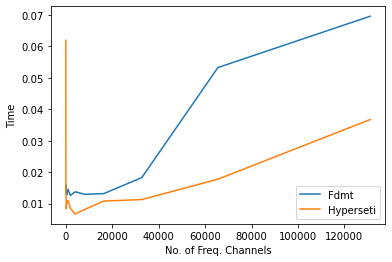

In [6]:
plt.plot(fchanslist,timesFDMT, label='Fdmt')
plt.plot(fchanslist,timesHyperseti, label='Hyperseti')
plt.xlabel('No. of Freq. Channels')
plt.ylabel('Time')  
plt.legend()
plt.show()

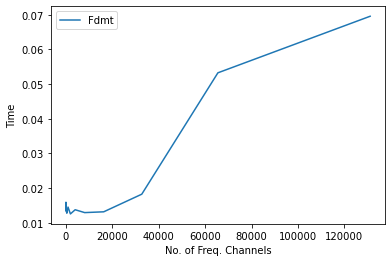

In [7]:
plt.plot(fchanslist,timesFDMT, label='Fdmt')
plt.xlabel('No. of Freq. Channels')
plt.ylabel('Time')  
plt.legend()
plt.show()

In [8]:
#!nvidia-smi

In [9]:
#ddframecenteredtwice(framegen(2**19,30,1,10,6095), 4*8192, 1)

import setigen as stg
import bifrost as bf
from bifrost.fdmt import Fdmt
import numpy as np
import blimpy as bl
import cupy as cp
import matplotlib.pyplot as plt
from astropy import units as u

import hyperseti
from hyperseti import dedoppler
from hyperseti import plotting 

from timeit import default_timer as timer
%matplotlib inline

fdmt= Fdmt()




def ddframecenteredtwice(stgframe, gulp_size, exponent):
    
    fr=stgframe
    drift_rate=fr.df/fr.dt
    frequency = fr.dt*fr.tchans*drift_rate
    max_delay=int(frequency*2)
    #print(max_delay)
    #max_delay = max_drift_rate
    gulp_size = gulp_size

    # def get_gulp(idx):
    #     d_cpu = np.ascontiguousarray(np.expand_dims(fr.data.squeeze(), axis=0)[..., idx * gulp_size:(idx+1) * gulp_size])
    #     return d_cpu
    
    # d_cpu = get_gulp(0)
    
    d_cpu = np.expand_dims(fr.data, axis=0)
    #print(d_cpu.shape)

    ## Initialize FDMT
    n_disp = max_delay
    n_time = d_cpu.shape[2]
    n_chan = d_cpu.shape[1]
    fdmt.init(n_chan, n_disp, fr.fch1, fr.df, space="cuda", exponent=exponent)


    # Input shape is (1, n_freq, n_time)
    d_in = bf.ndarray(d_cpu, dtype='f32', space='cuda')
    d_out = bf.ndarray(np.zeros(shape=(1, n_disp, n_time)), dtype='f32', space='cuda')

    # Execute FDMT
    fdmt.execute(d_in, d_out, negative_delays=True)
    d_out = d_out.copy(space='system')
    
    d_in = bf.ndarray(d_cpu, dtype='f32', space='cuda')
    d_out2 = bf.ndarray(np.zeros(shape=(1, n_disp, n_time)), dtype='f32', space='cuda')
    
    fdmt.execute(d_in, d_out2, negative_delays=False)
    d_out2 = d_out2.copy(space='system')
    
    fal=np.array(d_out2)
    fal=np.flip(fal, axis=1)
    data=np.concatenate((fal,np.array(d_out)), axis=1)
    
    #Peak Detection
    # img = cp.asarray(data.squeeze())
    # peaks, xvals, yvals = hyperseti.peak.prominent_peaks(img, num_peaks=1, min_xdistance=100, min_ydistance=100, threshold=100)
    # print(peaks)
    
    # #plotting the fdmt
    # plt.figure(figsize=(9, 6))
    # plt.imshow(np.log(np.concatenate((fal,np.array(d_out)), axis=1).squeeze()), aspect='auto', extent=[0, fr.fchans, -((max_delay/fr.tchans)*(fr.df/fr.dt)), ((max_delay/fr.tchans)*(fr.df/fr.dt))])
    # #, extent=[0, 1024, 0.23, 0]
    # plt.xlabel("Frequency")
    # plt.ylabel("Dispersion trial")
    # plt.colorbar()
    

    
def hypersetidd(frame):

    fr=frame
    drift_rate=fr.df/fr.dt
    frequency = fr.dt*fr.tchans*drift_rate
    max_delay=int(frequency*2)
    
    test_data = np.expand_dims(fr.data.astype('float32'), axis=1)

    metadata = {'frequency_start': frame.get_frequency(index=fr.fchans/2)*u.MHz, 'time_step': fr.dt*u.s, 'frequency_step': fr.df*u.Hz}

    # Run dedoppler

    dedopp, metadata= dedoppler(test_data, metadata, boxcar_size=1, max_dd=(max_delay/fr.tchans)*(fr.df/fr.dt))


    return dedopp

    # # Imshow output
    # plt.figure(figsize=(10, 6))
    # plt.subplot(1,2,1)
    # plotting.imshow_waterfall(np.log(test_data), metadata)
    # plt.subplot(1,2,2)
    # plotting.imshow_dedopp(np.log(dedopp), metadata)
    # plt.tight_layout()
    
    
    
def framegen(fchans,tchans,df,dt,fch1):
    frame = stg.Frame(fchans=fchans*u.pixel,
                      tchans=tchans*u.pixel,
                      df=df*u.Hz,
                      dt=dt*u.s,
                      fch1=fch1*u.MHz)
    noise = frame.add_noise(x_mean=10, noise_type='chi2')
    signal = frame.add_signal(stg.constant_path(f_start=frame.get_frequency(index=frame.fchans/2),
                                                drift_rate=frame.df/frame.dt),
                              stg.constant_t_profile(level=frame.get_intensity(snr=30)),
                              stg.box_f_profile(width=4*u.Hz),
                              stg.constant_bp_profile(level=1))
    return frame



#Comparing Performance

timesFDMT=[]
timesHyperseti=[]
fchanslist=[]
for i in range(5,13):
    fchans=2*(2**i)
    #print(1024*(2**i),i)
    fchanslist.append(fchans)
    frame=framegen(fchans,30,1,10,6095)
    
    start = timer()
    ddframecenteredtwice(frame, 4*8, 1)
    end = timer()
    
    timesFDMT.append(end - start)
    
    start = timer()
    hypersetidd(frame)
    end = timer()
    
    timesHyperseti.append(end - start)
    
plt.plot(fchanslist,timesHyperseti, label='Hyperseti')
plt.plot(fchanslist,timesFDMT, label='Fdmt')
plt.xlabel('No. of Freq. Channels')
plt.ylabel('Time')        
plt.legend()
plt.show()